# Enterococcus analysis

In [54]:
import pathlib
import os

root_dir = '/Users/ninast/Desktop/Whole_genome_analysis/enterococcus/'
json_paths = list(pathlib.Path(root_dir + 'resfinder_results').glob('*/data_resfinder.json'))
print(len(list(json_paths)))

15


In [55]:
import json

with open(json_paths[0], 'r') as f:
    raw_json = json.load(f)
    print(json.dumps(raw_json, indent=2))

{
  "resfinder": {
    "user_input": {
      "filename(s)": [
        "data/DTU2018-1181-PRJ1139-Enterococcus-faecium-1D-449_R1_001.trim.fq",
        "data/DTU2018-1181-PRJ1139-Enterococcus-faecium-1D-449_R2_001.trim.fq"
      ],
      "method": "kma",
      "file_format": "fastq"
    },
    "run_info": {
      "date": "22.04.2020",
      "time": "17:06:16"
    },
    "results": {
      "Aminoglycoside": {
        "aminoglycoside": {
          "aac(6')-aph(2'')_1_M13771": {
            "resistance_gene": "aac(6')-aph(2'')",
            "identity": 99.93,
            "HSP_length": 1440,
            "template_length": 1440,
            "position_in_ref": "1..1441",
            "contig_name": "NA",
            "positions_in_contig": "NA..NA",
            "note": "1",
            "accession": "M13771",
            "predicted_phenotype": "Aminoglycoside resistance",
            "coverage": 100.0,
            "hit_id": "aac(6')-aph(2'')_1_M13771",
            "subject_header": "aac(6')-aph(2

In [56]:
import pandas as pd 

jsons = [json.load(open(path, 'r'))['resfinder'] for path in json_paths]
df = pd.json_normalize(jsons)

In [57]:
sample_type_and_hospital_for_name = {
    'DTU2018-1181-PRJ1139-Enterococcus-faecium-1D-449_R1_001.trim.fq': ['urine', 'F9'],
    'DTU2019-1471-PRJ1139-Enterococcus-faecium-1D-1482_R1_001.trim.fq': ['blood', 'F1'],
    'DTU2018-1179-PRJ1139-Enterococcus-faecium-1D-447_R1_001.trim.fq': ['blood', 'F5'],
    'DTU2018-1177-PRJ1139-Enterococcus-faecium-1D-445_R1_001.trim.fq': ['blood', 'F3'],
    'DTU2019-1469-PRJ1139-Enterococcus-faecium-1D-1480_R1_001.trim.fq': ['blood', 'F1'],
    'DTU2019-1483-PRJ1139-Enterococcus-faecium-1D-1495_R1_001.trim.fq':['urine', 'F1'],
    'DTU2019-1470-PRJ1139-Enterococcus-faecium-1D-1481_R1_001.trim.fq': ['blood', 'F1'],
    'DTU2018-1186-PRJ1139-Enterococcus-sp-1D-454_R1_001.trim.fq': ['urine', 'F3'],
    'DTU2019-1487-PRJ1139-Enterococcus-faecium-1D-1499_R1_001.trim.fq': ['urine','F1'],
    'DTU2018-1178-PRJ1139-Enterococcus-faecium-1D-446_R1_001.trim.fq': ['urine', 'F5'],
    'DTU2018-1176-PRJ1139-Enterococcus-faecium-1D-444_R1_001.trim.fq': ['blood', 'F1'],
    'DTU2019-1493-PRJ1139-Enterococcus-faecium-1D-1505_R1_001.trim.fq': ['urine', 'F1'],
    'DTU2019-1466-PRJ1139-Enterococcus-faecium-1D-1477_R1_001.trim.fq': ['blood', 'F1'],
    'DTU2018-1180-PRJ1139-Enterococcus-faecium-1D-448_R1_001.trim.fq': ['urine', 'F7'],
    'DTU2019-1492-PRJ1139-Enterococcus-faecium-1D-1504_R1_001.trim.fq': ['urine', 'F1'],
}

def get_sample_type_and_hospital_for_name(name):
    return sample_type_and_hospital_for_name[name]

In [58]:
data = []
type_for_gene_name = {}
for path in json_paths:
    with open(path, 'r') as f:
        raw_json = json.load(f)
        
    stripped_result = {} 
    name = pathlib.Path(raw_json['resfinder']['user_input']["filename(s)"][0]).name
    stripped_result['name'] = name
    sample_type_hospital = get_sample_type_and_hospital_for_name(name) 
    stripped_result['sample_type'] = sample_type_hospital[0]
    stripped_result['hospital'] = sample_type_hospital[1]

    results_json = raw_json['resfinder']['results']
    for db_json in results_json.values():
        for gene_type, genes in db_json.items():
            if isinstance(genes, dict):
                for x in genes.keys():
                    stripped_name = x.rsplit('_', 1)[0]
                    stripped_result[stripped_name] = 1
                    type_for_gene_name[stripped_name] = gene_type
    
    data.append(stripped_result)

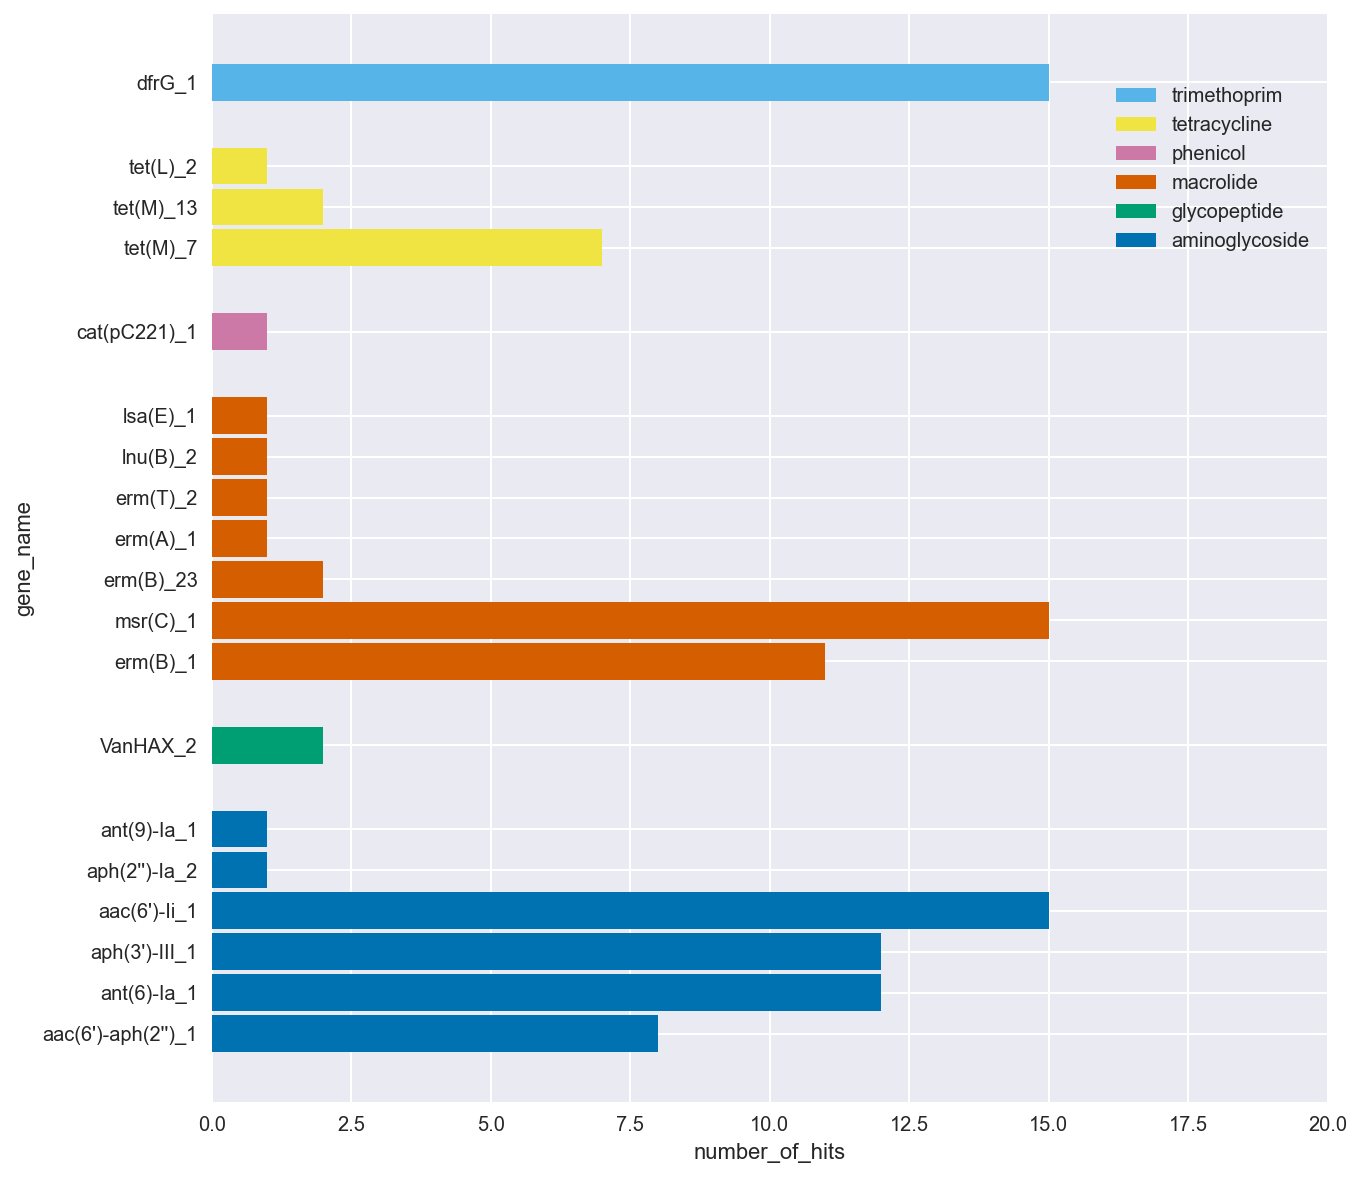

In [99]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-colorblind')
%config InlineBackend.figure_format = 'retina'

df = pd.DataFrame(data)
df_t = df.transpose().drop('name')
df_t['gene_type'] = df_t.index.map(type_for_gene_name)
df_t = df_t.reset_index()
df_t.set_index(['gene_type', 'index'], inplace=True)
df_t = df_t.sum(1)

groups = df_t.index.levels[0].tolist()

margin = 0.05
distance_between_groups = 2
current_pos = 0

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

all_positions = []
all_labels = []
for num, group_name in enumerate(groups):
    df_group = df_t.groupby(level=0).get_group(group_name).unstack()
    df_group_t = df_group.transpose()

    group_values = df_group.values.tolist()
    group_values = [item for sublist in group_values for item in sublist]

    xdata = np.arange(current_pos + margin, current_pos + len(group_values)) 
    current_pos = xdata[-1] + distance_between_groups

    group_labels = df_group_t.index.tolist()

    all_positions.extend(xdata)
    all_labels.extend(group_labels)

    ax.barh(xdata, group_values, height=0.9, label=group_name, align='center')

plt.xlabel('number_of_hits')
plt.ylabel('gene_name')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 0.95))

ax.set_xlim((0, 20))

ax.set_yticks(all_positions)
ax.set_yticklabels(all_labels)

plt.savefig('histogram.png')

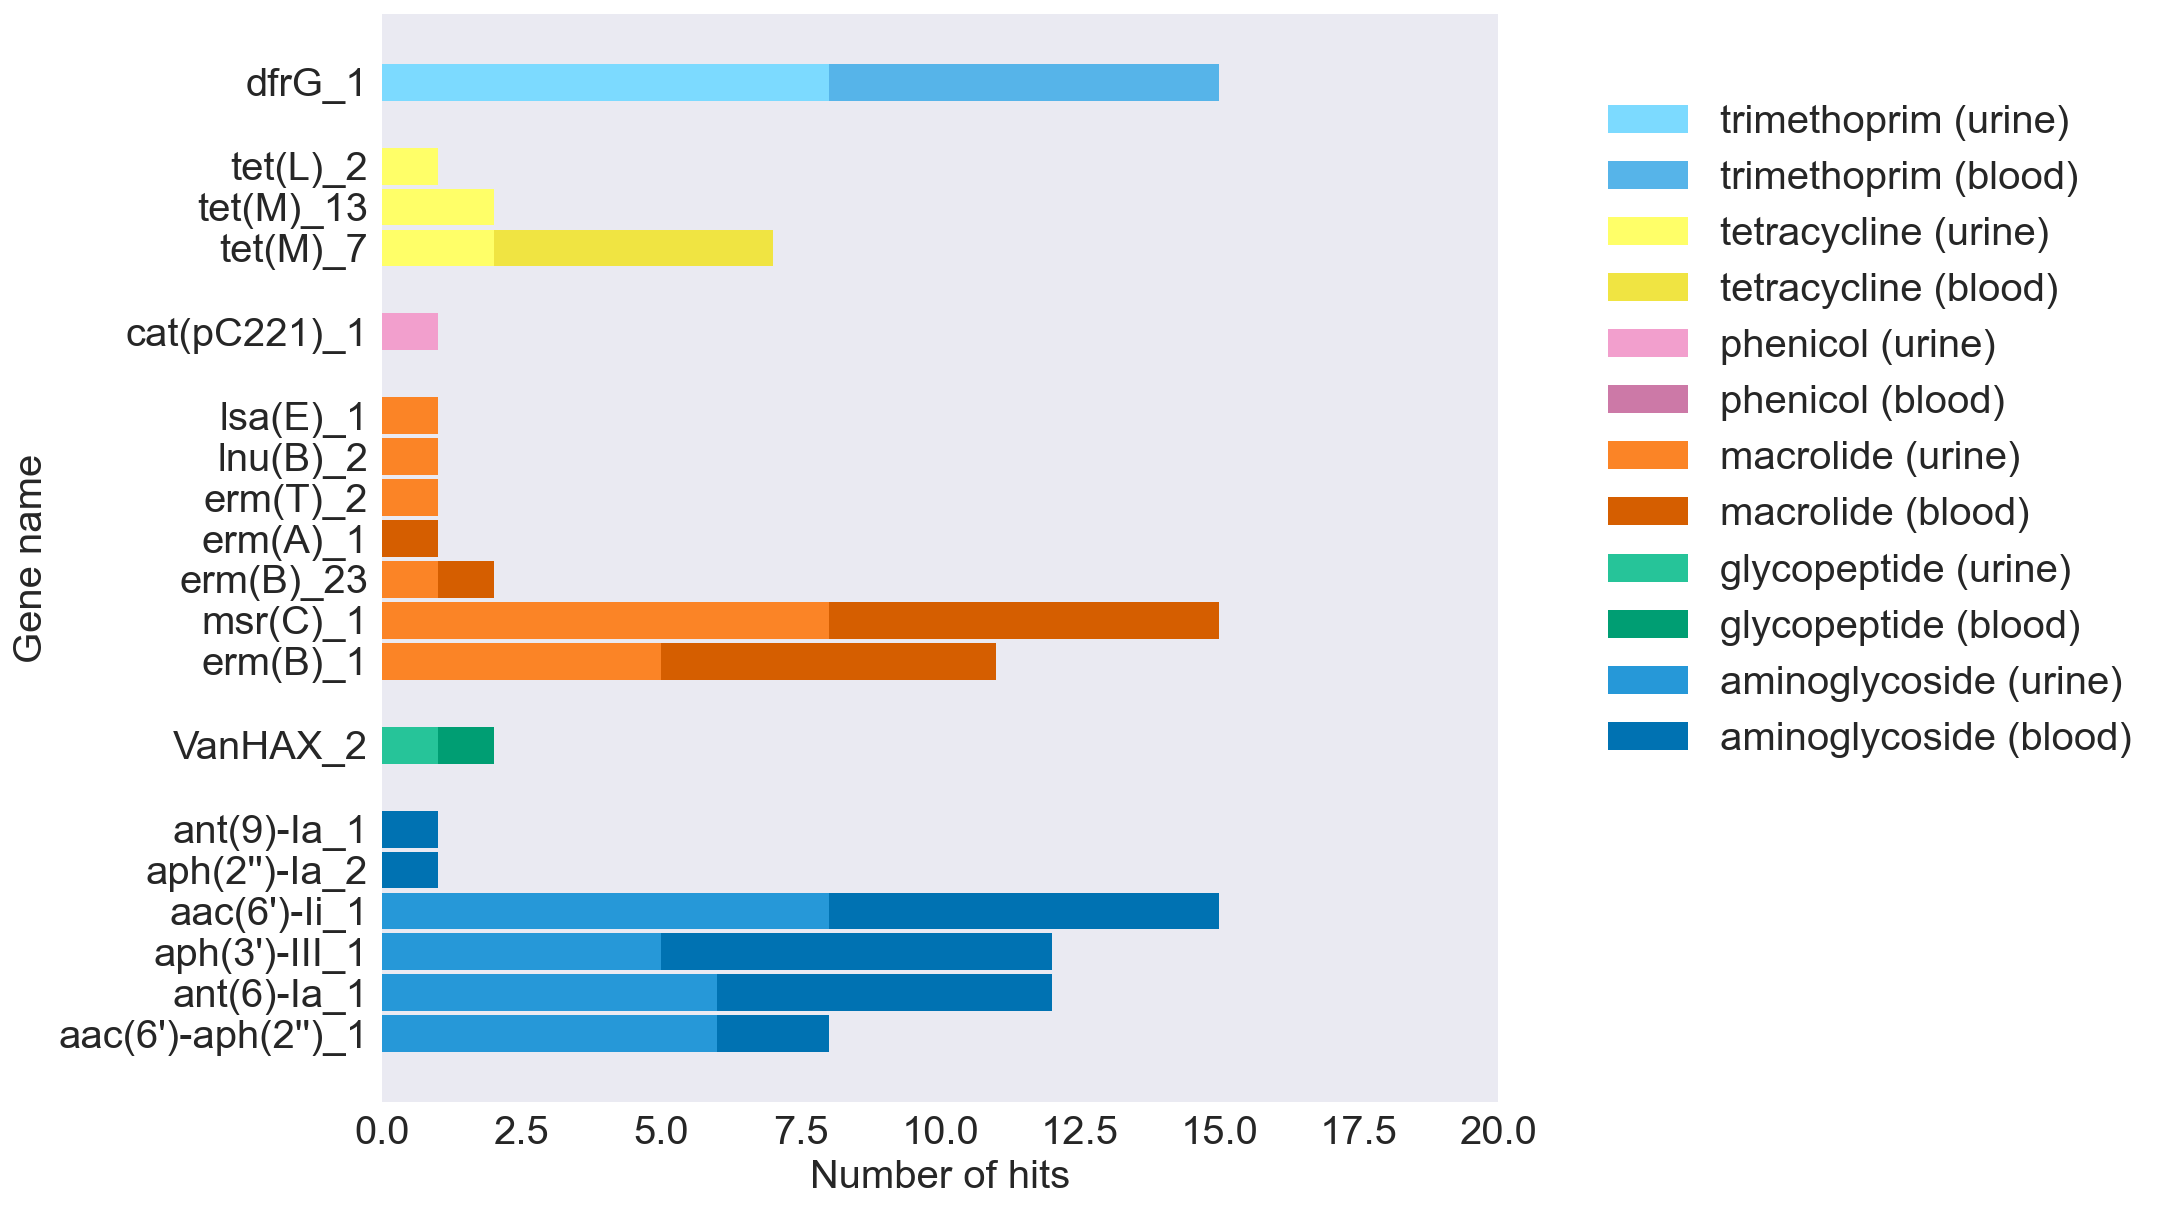

In [100]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-colorblind')
%config InlineBackend.figure_format = 'retina'

df = pd.DataFrame(data)
df_t = df.transpose().drop('name')
df_t['gene_type'] = df_t.index.map(type_for_gene_name)
urine_t = df_t.transpose()[df_t.transpose()['sample_type'] != 'blood'].transpose().drop('sample_type')

urine_t = urine_t.reset_index()
urine_t.set_index(['gene_type', 'index'], inplace=True)
urine_t = urine_t.sum(1)

df_t = df_t.drop('sample_type')
df_t = df_t.reset_index()
df_t.set_index(['gene_type', 'index'], inplace=True)
df_t = df_t.sum(1)

groups = df_t.index.levels[0].tolist()

margin = 0.05
distance_between_groups = 2
current_pos = 0

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

all_positions = []
all_labels = []
for num, group_name in enumerate(groups):
    df_group = df_t.groupby(level=0).get_group(group_name).unstack()
    df_group_t = df_group.transpose()
    
    df_urine_group = urine_t.groupby(level=0).get_group(group_name).unstack()
    df_urine_group = df_urine_group.transpose()
    urine_values = df_urine_group.values.tolist()
    urine_values = [item for sublist in urine_values for item in sublist]

    group_values = df_group.values.tolist()
    group_values = [item for sublist in group_values for item in sublist]

    xdata = np.arange(current_pos + margin, current_pos + len(group_values)) 
    current_pos = xdata[-1] + distance_between_groups

    group_labels = df_group_t.index.tolist()

    all_positions.extend(xdata)
    all_labels.extend(group_labels)

    bplot = ax.barh(xdata, group_values, height=0.9, label=group_name + ' (blood)', align='center')
    color = bplot[0].get_facecolor()
    color = [min(x + 0.15, 1.0) for x in color if x != 1]
    urine_bars = ax.barh(xdata, urine_values, height=0.9, label=group_name + ' (urine)', align='center', color=color)


plt.xlabel('Number of hits', size=20)
plt.ylabel('Gene name', size=20)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.6, 0.95), prop={"size":20})

ax.set_xlim((0, 20))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_yticks(all_positions)
ax.set_yticklabels(all_labels, size=20);
ax.grid(False)

plt.savefig('sample_type_histogram.png', bbox_inches='tight')

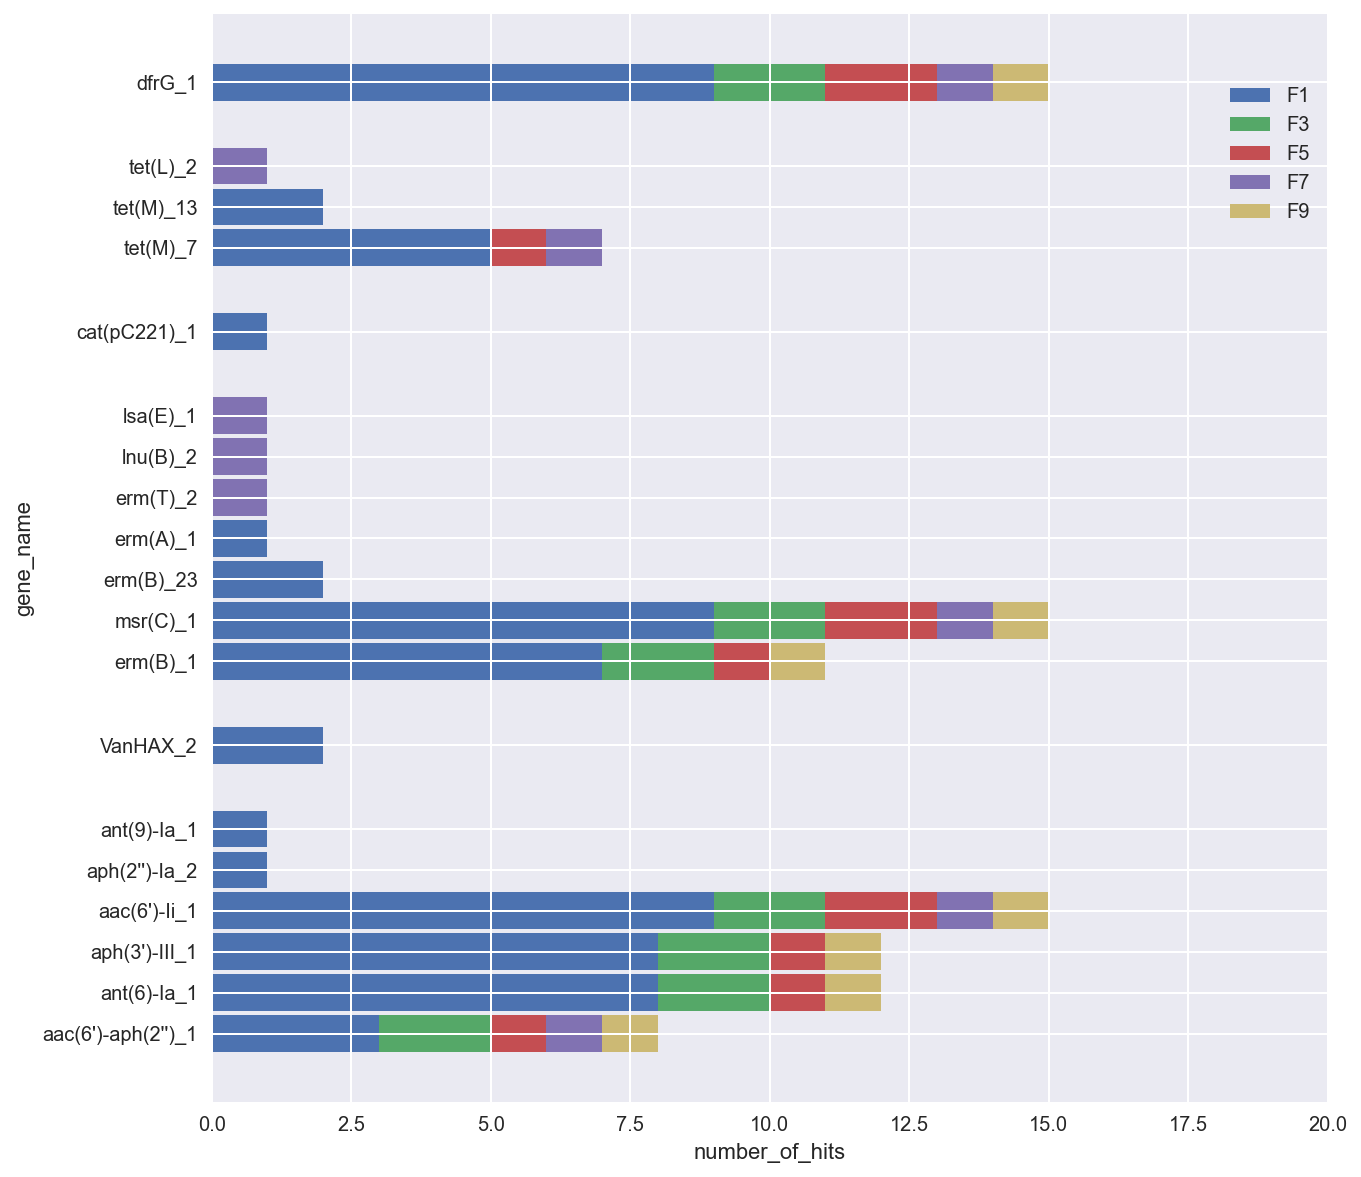

In [67]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

%config InlineBackend.figure_format = 'retina'

df = pd.DataFrame(data)
df_t = df.transpose().drop('name').drop('sample_type')

hospital_counts = df_t.transpose().groupby('hospital').count().transpose()
hospital_counts['gene_type'] = hospital_counts.index.map(type_for_gene_name)

hospital_counts = hospital_counts.reset_index()
hospital_counts.set_index(['gene_type', 'index'], inplace=True)

plot_input = hospital_counts

labels = hospital_counts.columns.tolist()

groups = plot_input.index.levels[0].tolist()
margin = 0.05
distance_between_groups = 2
current_pos = 0

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

color_map = plt.rcParams['axes.prop_cycle'].by_key()['color']

all_positions = []
all_labels = []
for num, group_name in enumerate(groups):
    df_group = plot_input.groupby(level=0).get_group(group_name)
    
    genes = df_group.index.get_level_values(1).tolist()
    all_labels.extend(genes)
    
    xdata = np.arange(current_pos + margin, current_pos + len(genes)) 
    current_pos = xdata[-1] + distance_between_groups
    all_positions.extend(xdata)
    
    bar_height = [0 for x in range(len(genes))]
    for i, hospital_name in enumerate(df_group.columns):
        add_height = df_group[hospital_name].values
        bar_height = [bar_height[i] + add_height[i] for i in range(len(genes))]
        ax.barh(xdata, 
                bar_height, 
                height=0.9, 
                label=hospital_name, 
                align='center', 
                zorder=len(genes) - 10 - i,
                color=color_map[i]) # -10 so that it's not above axis line
    
plt.xlabel('number_of_hits')
plt.ylabel('gene_name')

plt.legend(labels, bbox_to_anchor=(1.0, 0.95))

ax.set_xlim((0, 20))

ax.set_yticks(all_positions)
ax.set_yticklabels(all_labels);

plt.savefig('hospital_histogram.png')

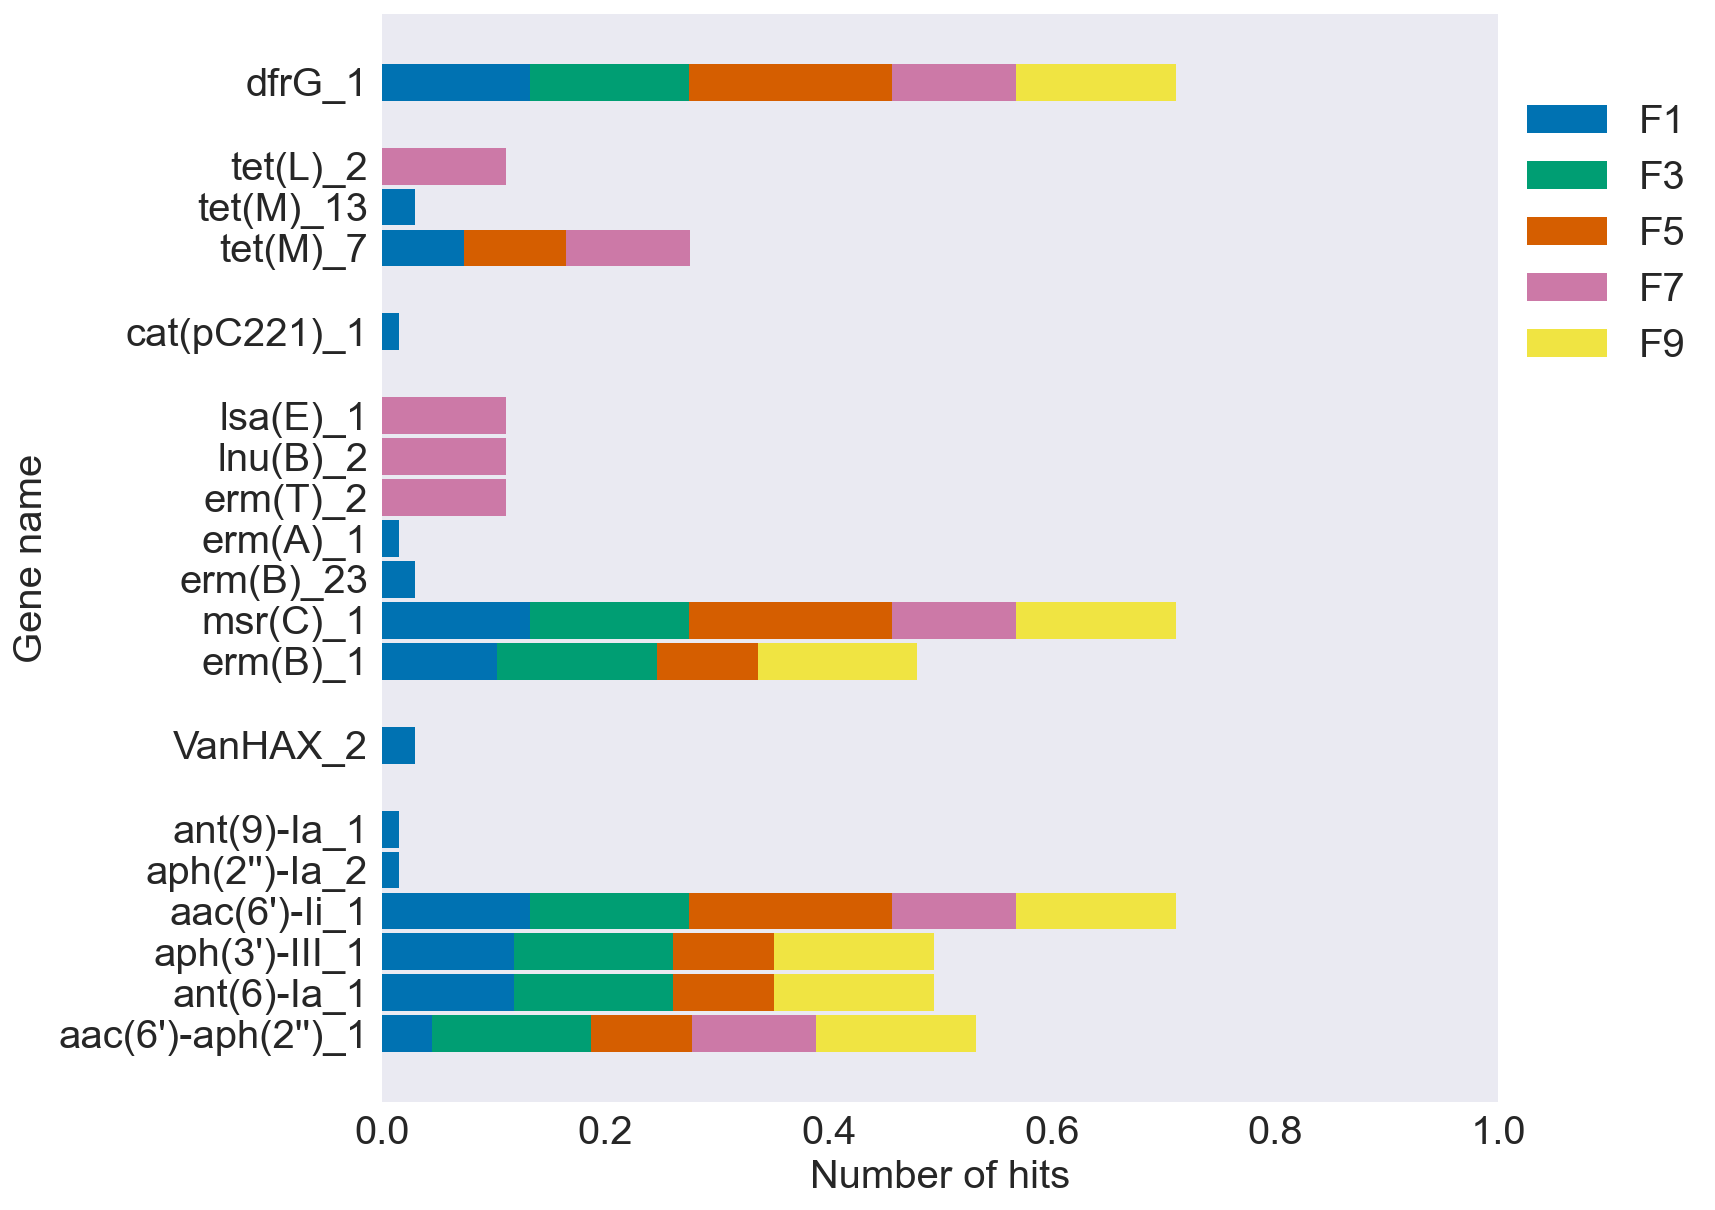

In [101]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-colorblind')

df = pd.DataFrame(data)
df_t = df.transpose().drop('name').drop('sample_type')

hospital_counts = df_t.transpose().groupby('hospital').count().transpose()
hospital_counts['gene_type'] = hospital_counts.index.map(type_for_gene_name)

hospital_counts = hospital_counts.reset_index()
hospital_counts.set_index(['gene_type', 'index'], inplace=True)

plot_input = hospital_counts

hospital_sums = plot_input.sum()

labels = hospital_counts.columns.tolist()

groups = plot_input.index.levels[0].tolist()
margin = 0.05
distance_between_groups = 2
current_pos = 0

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

color_map = plt.rcParams['axes.prop_cycle'].by_key()['color']

all_positions = []
all_labels = []
for num, group_name in enumerate(groups):
    df_group = plot_input.groupby(level=0).get_group(group_name)
    
    genes = df_group.index.get_level_values(1).tolist()
    all_labels.extend(genes)
    
    xdata = np.arange(current_pos + margin, current_pos + len(genes)) 
    current_pos = xdata[-1] + distance_between_groups
    all_positions.extend(xdata)
    
    bar_height = [0 for x in range(len(genes))]
    for i, hospital_name in enumerate(df_group.columns):
        add_height = df_group[hospital_name].values 
        bar_height = [bar_height[i] + (add_height[i] / hospital_sums[hospital_name]) 
                                       for i in range(len(genes))]
        ax.barh(xdata, 
                bar_height, 
                height=0.9, 
                label=hospital_name, 
                align='center', 
                zorder=len(genes) + 10 - i,
                color=color_map[i]) # -10 so that it's not above axis line
    
plt.xlabel('Number of hits', size=20)
plt.ylabel('Gene name', size=20)

plt.legend(labels, bbox_to_anchor=(1.2, 0.95), prop={"size":20})

ax.set_xlim((0, 1))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_yticks(all_positions)
ax.set_yticklabels(all_labels, size=20);

ax.grid(False)

plt.savefig('normalized_hospital_histogram.png', bbox_inches='tight')